In [70]:
import os
import gc
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import (Dense, InputLayer, Conv2D, MaxPooling2D, Flatten, 
                                     GlobalAveragePooling2D, Dropout)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import (SparseCategoricalCrossentropy, CategoricalCrossentropy)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [71]:
PATH_train = '/kaggle/input/apple-image-dataset/'
IMAGE_SIZE = 64
BATCH_SIZE = 32

In [72]:
data = []
label = []

class_before = np.sort(os.listdir(PATH_train))

for class_name in class_before:
    print(f'Name: {class_name}')
    for file_total in tqdm(os.listdir(PATH_train + class_name)):
        names = class_before
        names = np.where(names != class_name, 0.0, names)
        names = np.where(names == class_name, 1.0, names)
        image_file = PATH_train + class_name +'/'+ file_total
        data.append(np.asarray(Image.open(image_file).resize((IMAGE_SIZE, IMAGE_SIZE)).convert('RGB')))
        label.append(names)

Name: Apple___Apple_scab


100%|██████████| 630/630 [00:01<00:00, 538.88it/s]


Name: Apple___Black_rot


100%|██████████| 621/621 [00:01<00:00, 522.83it/s]


Name: Apple___Cedar_apple_rust


100%|██████████| 275/275 [00:00<00:00, 537.89it/s]


Name: Apple___healthy


100%|██████████| 1645/1645 [00:03<00:00, 475.75it/s]


In [73]:
data = np.array(data, dtype='float32') / 255
label = np.array(label, dtype='float32')

In [74]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

In [75]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 1 - train_ratio, random_state=123)

In [76]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio / (test_ratio + validation_ratio), random_state=123)

In [77]:
print(f'Data: {np.shape(data)}')
print(f'Label: {np.shape(label)}')
print(f'x_train: {np.shape(x_train)}')
print(f'y_train: {np.shape(y_train)}')
print(f'x_val: {np.shape(x_val)}')
print(f'y_val: {np.shape(y_val)}')
print(f'x_test: {np.shape(x_test)}')
print(f'y_test: {np.shape(y_test)}')

Data: (3171, 64, 64, 3)
Label: (3171, 4)
x_train: (2536, 64, 64, 3)
y_train: (2536, 4)
x_val: (317, 64, 64, 3)
y_val: (317, 4)
x_test: (318, 64, 64, 3)
y_test: (318, 4)


In [78]:
datagen = ImageDataGenerator(
#         rotation_range=30,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
#         fill_mode = 'nearest',
        shear_range = 10
)

<class 'numpy.ndarray'>


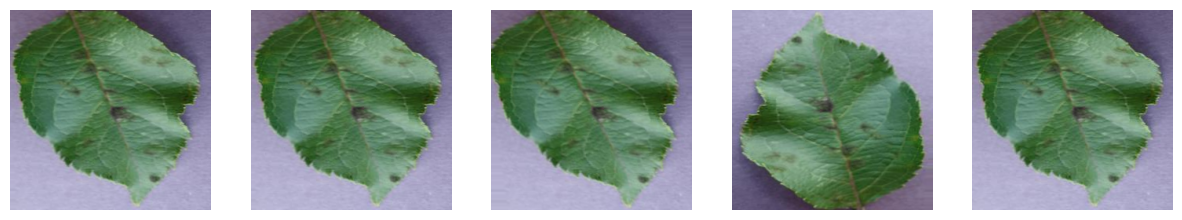

In [79]:
img = io.imread("/kaggle/input/apple-image-dataset/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG",)
img = img.reshape((1, ) + img.shape)

print(type(img))
aug_iter = datagen.flow(img, batch_size=1)

fig, ax = plt.subplots(1, 3, figsize=(15,15))

# generate batch of images
for i in range(5):
    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
    
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

In [80]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.9:
            self.model.stop_training = True

callbacks = CustomCallback()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.0001)
early_stopping = EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)

In [81]:
def create_model():
    model = Sequential([
        Conv2D(64, 3, activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        MaxPooling2D(2, 2),
        Conv2D(32, 3, activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(0.001),
              metrics=['accuracy'])

    return model

In [82]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                      

In [83]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                    validation_data = (x_val, y_val),
                    epochs=200,
                    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                    callbacks=[early_stopping])

Epoch 1/200
79/79 [==============================] - 4s 34ms/step - loss: 1.2174 - accuracy: 0.5028 - val_loss: 1.1359 - val_accuracy: 0.5489
Epoch 2/200
79/79 [==============================] - 3s 35ms/step - loss: 1.1346 - accuracy: 0.5180 - val_loss: 1.1042 - val_accuracy: 0.5300
Epoch 3/200
79/79 [==============================] - 3s 34ms/step - loss: 0.9726 - accuracy: 0.5799 - val_loss: 0.9369 - val_accuracy: 0.5804
Epoch 4/200
79/79 [==============================] - 3s 33ms/step - loss: 0.8365 - accuracy: 0.6506 - val_loss: 0.9072 - val_accuracy: 0.6530
Epoch 5/200
79/79 [==============================] - 3s 32ms/step - loss: 0.8031 - accuracy: 0.6793 - val_loss: 0.7165 - val_accuracy: 0.7035
Epoch 6/200
79/79 [==============================] - 3s 35ms/step - loss: 0.6811 - accuracy: 0.7181 - val_loss: 0.6350 - val_accuracy: 0.7571
Epoch 7/200
79/79 [==============================] - 3s 33ms/step - loss: 0.6205 - accuracy: 0.7488 - val_loss: 0.6105 - val_accuracy: 0.7666
Epoch 

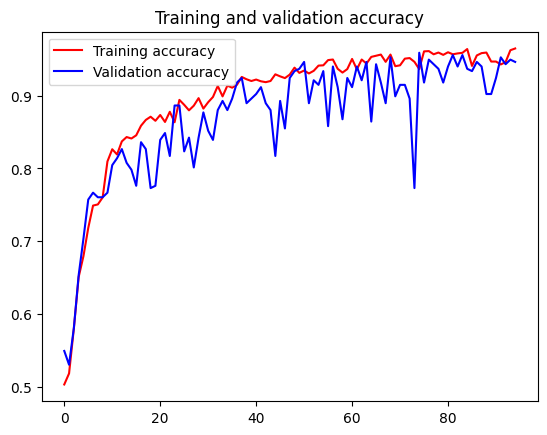

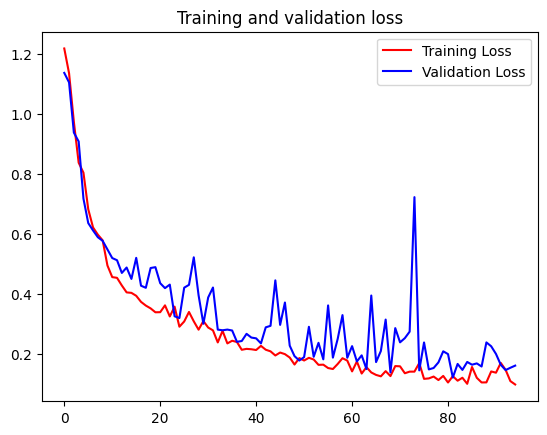

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [85]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# target = (y_pred > 0.5).astype(np.float32)
print(classification_report(y_true, y_pred, target_names=class_before))

10/10 [==============================] - 0s 2ms/step
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.92      0.87      0.90        55
       Apple___Black_rot       0.89      1.00      0.94        67
Apple___Cedar_apple_rust       0.96      0.85      0.90        26
         Apple___healthy       0.98      0.97      0.98       170

                accuracy                           0.95       318
               macro avg       0.94      0.92      0.93       318
            weighted avg       0.95      0.95      0.95       318

